


## Import/Install Modules

In [ ]:

# Imports
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
import matplotlib
import random
import pickle as pk
import os
from scipy.stats import uniform, randint, beta

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr

import sys
import statsmodels
!pip install demoji
import demoji
!pip install -U sentence-transformers
!pip install umap-learn
import umap
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, InputLayer, BatchNormalization, LeakyReLU, Normalization, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import GridSearchCV

#!pip install scikeras==0.1.8
#from scikeras.wrappers import KerasClassifier
from keras.metrics import AUC

import xgboost as xgb
from xgboost import XGBClassifier

from scipy.stats import ttest_ind, spearmanr
from glob import glob

In [6]:
# Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Change directory
%cd /content/drive/MyDrive/Negatively Biased Credulity/Data/Twitter/Cleaned Data

/content/drive/MyDrive/Negatively Biased Credulity/Data/Twitter/Cleaned Data


## Install and Import Libraries

## Read Dataset

In [23]:
#Preprocessed data
#annotations
file='Tweet annotation.csv'

data = pd.read_csv(file,low_memory=False,lineterminator='\n')


In [ ]:

# clean data
# make columns readable
data.columns = [c.replace('_1','') if not ('_' in c and 'Q' not in c) else 'Q'+c.replace('_1','') for c in data.columns]
# this question checks if someone is paying attention; everyone chose "4" so it is not needed
data = data.drop(['Q11119'],axis=1)
cols = data.columns

# where are the questions for each text located
pos_qs = [ii for ii,c in enumerate(cols) if 'Q' in c]
# number of questions per annotations
num_qs = 11
# where do the questions start (starting from the first and ending at the 10th annotation)
q_start_pos = [22-num_qs]+pos_qs[5::11]

# here we extract the exact questions
col_text = {}
for c in cols:
    col_text[c] = data.iloc[0][c]
questions = [col_text[c] for c in cols[q_start_pos[1]:q_start_pos[1]+11]]
# demographics
demogs = [col_text[c] for c in cols if 'QD' in c]
# all of the key data: text, questions, demographics per annotator
annotations = {'text':[]}
for q in questions:
    annotations[q] = []
for d in demogs:
    annotations[d] = []

# data cleaning
data = data[12:]
# find all data where humans completed the task and took > 3 minutes, 20 seconds (200 seconds)
data = data.loc[data['Progress'].astype(float).values==100,]
data = data.loc[data['Duration (in seconds)'].astype(float).values>200,]

# for each row of this file, find the exact text humans annotated
for ii,row in data.iterrows():
    if ii > 0:
        # all the tweets are those whose elements are not null and not questions
        texts = [col_text[c] for null,c in zip(row.isnull()[q_start_pos[0]+num_qs:],cols[q_start_pos[0]+num_qs:]) if not null and 'Q' not in c and c in col_text.keys()][:-4]
        line_annots = {}
        # for each text,
        for q1,text in zip(q_start_pos[1:],texts):
            # positions of all the questions associated with the text
            q_cols = cols[q1:q1+num_qs]
            # add tweet
            line_annots['text'] = [text]
            # add questions
            for q,c in zip(questions,q_cols):
                line_annots[q]=[row[c]]
            for c in cols:
                # demographic questions
                if 'QD' in c:
                    line_annots[col_text[c]]=[row[c]]
        # if we have found all the data
        if set(list(line_annots.keys()))== set(list(annotations.keys())):
            # append text, questions, demographics
            for q1,text in zip(q_start_pos[1:],texts):
                q_cols = cols[q1:q1+num_qs]
                annotations['text'].append(text)
                for q,c in zip(questions,q_cols):
                    annotations[q].append(row[c])
                for c in cols:
                    if 'QD' in c:
                        annotations[col_text[c]].append(row[c])
            lens= []
            for key in annotations.keys():
                lens.append(len(annotations[key]))
for c in annotations.keys():
    print([c,len(annotations[c])])
annotations = pd.DataFrame(annotations)




In [ ]:
# convert tweet emojis into embeddable format, embed



## Training model

In [11]:

# Reset index
# Model #Avoid overfitting using dropout layers, batch normalization, feature normalization, regularization, and leaky relu/elu
embedding_dim = 768

metrics = {'NN_auc':[],'NN_f1':[],'RF_auc':[],'RF_f1':[],'SVM_auc':[],'SVM_f1':[],'XGB_auc':[],'XGB_f1':[],'gpt_auc':[],'gpt_f1':[],'base_f1':[]}
metrics = {'gpt_auc':[],'gpt_f1':[],'gpt_soc_auc':[],'gpt_soc_f1':[],'gpt_lib_auc':[],'gpt_lib_f1':[],'gpt4_auc':[],'gpt4_f1':[]}
for ii in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.9, random_state=ii)
    y_train = y_train[:,0].round()
    gpt_p = y_test[:,1]
    gpt_s_p = y_test[:,2]
    gpt4_p = y_test[:,3]
    gptl_p = y_test[:,4]
    y_test = y_test[:,0].round()
    auc = roc_auc_score(y_test, gpt_p)
    f1=f1_score(y_test, gpt_p)
    metrics['gpt_auc'].append(auc)
    metrics['gpt_f1'].append(f1)
    auc = roc_auc_score(y_test, gpt_s_p)
    f1=f1_score(y_test, gpt_s_p)
    metrics['gpt_soc_auc'].append(auc)
    metrics['gpt_soc_f1'].append(f1)
    auc = roc_auc_score(y_test, gpt4_p)
    f1=f1_score(y_test, gpt4_p)
    metrics['gpt4_auc'].append(auc)
    metrics['gpt4_f1'].append(f1)
    auc = roc_auc_score(y_test, gptl_p)
    f1=f1_score(y_test, gptl_p)
    metrics['gpt_lib_auc'].append(auc)
    metrics['gpt_lib_f1'].append(f1)
    if False:

      embedding_normalizer = Normalization(input_shape=[embedding_dim,], axis=None)
      embedding_normalizer.adapt(X_train)
      def modeling(l2_lambda=0.001, relu_alpha=0.1, dropout_rate=0.7):
          model = Sequential([
          embedding_normalizer,
          Dense(int(embedding_dim/3),kernel_regularizer=regularizers.l2(l2_lambda)),
          LeakyReLU(relu_alpha), #alpha=negative coefficient for the slope
          BatchNormalization(),
          Dropout(dropout_rate),
          Dense(int(embedding_dim/9), kernel_regularizer=regularizers.l2(l2_lambda)),
          LeakyReLU(relu_alpha),
          BatchNormalization(),
          Dropout(dropout_rate),
          Dense(int(embedding_dim/27),kernel_regularizer=regularizers.l2(l2_lambda)),
          LeakyReLU(relu_alpha),
          BatchNormalization(),
          Dropout(dropout_rate),
          Dense(1, activation=tf.keras.activations.sigmoid)
          ])
          model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy',AUC()])
          return model

      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #min_delta=1 #baseline=26


      m = modeling()
      #history = m.fit(X_pseudo, y_pseudo, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])

      history = m.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])
      y_pred = m.predict(X_test)
      metrics['NN_auc'].append(roc_auc_score(y_test, y_pred))
      metrics['NN_f1'].append(f1_score(y_test,y_pred.round()))
      #,'RF_auc':[],'RF_f1':[],'SVM_auc':[],'SVM_f1':[],'XGB_auc':[],'XGB_f1':[]}
      clf = RandomForestClassifier(max_depth=10, random_state=42)
      clf.fit(X_train, y_train)

      pred_prob = clf.predict_proba(X_test)[:,1]
      pred = clf.predict(X_test)
      auc = roc_auc_score(y_test, pred_prob)
      f1=f1_score(y_test, pred)
      metrics['RF_auc'].append(auc)
      metrics['RF_f1'].append(f1)
      clf = SVC(probability=True)
      clf.fit(X_train, y_train)

      pred_prob = clf.predict_proba(X_test)[:,1]
      pred = clf.predict(X_test)
      auc = roc_auc_score(y_test, pred_prob)
      f1=f1_score(y_test, pred)
      metrics['SVM_auc'].append(auc)
      metrics['SVM_f1'].append(f1)

      clf = XGBClassifier()
      clf.fit(X_train, y_train)

      pred_prob = clf.predict_proba(X_test)[:,1]
      auc = roc_auc_score(y_test, pred_prob)

      pred = clf.predict(X_test)
      f1=f1_score(y_test, pred)
      metrics['XGB_auc'].append(auc)
      metrics['XGB_f1'].append(f1)
      f1_base=f1_score(y_test,[1]*len(y_test))
      metrics['base_f1'].append(f1_base)

pd.DataFrame(metrics).to_csv('metrics_gpt_vs_gpt_s.csv',index=False)



### GPT responses for whether a hazard exists in text. We convert "yes"/"no" into 1 (yes) or 0 (no)

In [36]:
tweet_gpt = pd.read_csv('tweet_responses.csv')
tweet_gpt['gpt-3.5-turbo'] = [1 if 'yes' in res.lower() else 0 for res in tweet_gpt['gpt-3.5-turbo'].values]
tweet_gpt['gpt-4'] = [1 if 'yes' in res.lower() else 0 for res in tweet_gpt['gpt-4'].values]
gpt_results = pd.merge(GT_labels,tweet_gpt,left_on='old_text',right_on='text')
print([len(GT_labels),len(gpt_results)])
gpt_results = gpt_results[['hazard','gpt-3.5-turbo','gpt-4']]
all_auc_gpt = {'GPT-3.5':[],'GPT-4':[]}
for i in range(1000):
  boot = gpt_results.sample(frac=1.0,replace=True)
  auc_35 = roc_auc_score(boot['hazard'].values.round(),boot['gpt-3.5-turbo'].values)
  all_auc_gpt['GPT-3.5'].append(auc_35)
  auc_4 = roc_auc_score(boot['hazard'].values.round(),boot['gpt-4'].values)
  all_auc_gpt['GPT-4'].append(auc_4)
auc_gpt_summary = {}
auc_gpt_summary['GPT-3.5']=[round(np.mean(all_auc_gpt['GPT-3.5']),3),round(np.std(all_auc_gpt['GPT-3.5']),3),1000]
auc_gpt_summary['GPT-4']=[round(np.mean(all_auc_gpt['GPT-4']),3),round(np.std(all_auc_gpt['GPT-4']),3),1000]


[1312, 1312]


### Plotting model performance on held out data

Index(['NN_auc', 'NN_f1', 'RF_auc', 'RF_f1', 'SVM_auc', 'SVM_f1', 'XGB_auc',
       'XGB_f1', 'base_f1'],
      dtype='object')
Index(['NN_auc', 'RF_auc', 'SVM_auc', 'XGB_auc', 'NN-pre_auc', 'GPT-3.5',
       'GPT-4'],
      dtype='object')


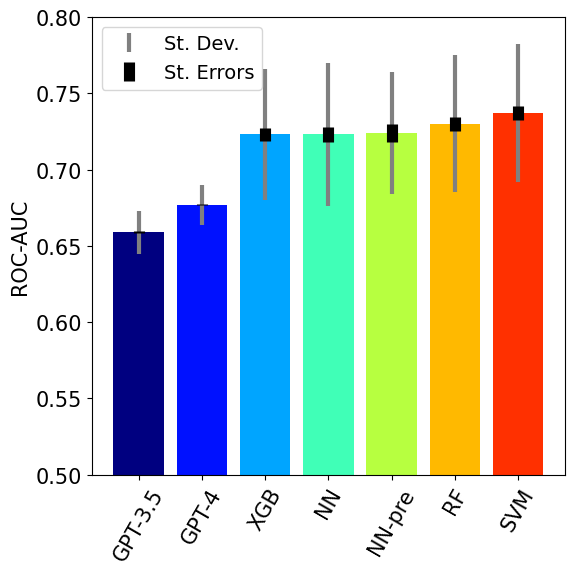

In [43]:

matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}
aucs={}

metrics = pd.read_csv('metrics.csv')
print(metrics.columns)
for col in metrics.columns:
  if 'auc' in col:
      aucs[col]=[round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3),len(metrics[col])]
metrics = pd.read_csv('metrics_gpt.csv')
for col in metrics.columns:
  if 'NN_auc' in col:
      aucs['NN-pre_auc']=[round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3),len(metrics[col])]
aucs['GPT-3.5'] = auc_gpt_summary['GPT-3.5']
aucs['GPT-4'] = auc_gpt_summary['GPT-4']
aucs = pd.DataFrame(aucs)
print(aucs.columns)
cols = ['GPT-3.5','GPT-4','XGB_auc','NN_auc','NN-pre_auc','RF_auc','SVM_auc']

bars = [aucs[c][0] for c in cols]#'GPT3.5-SocCons_auc','GPT3.5-LibCons_auc','GPT4_auc',
stds = [aucs[c][1] for c in cols]

ax,fig = plt.subplots(1,1,figsize=(6,6))
errors = [aucs[c][1]/np.sqrt(aucs[c][2]) for c in cols]# 'GPT3.5-SocCons_auc','GPT3.5-LibCons_auc','GPT4_auc',
jet = plt.get_cmap('jet')
plt.bar(list(range(len(cols))),bars,color=[jet(i/(len(cols))) for i in range(len(aucs.columns))])
plt.errorbar(list(range(len(cols))),bars,yerr=stds,color='gray',linestyle='',linewidth=3,label='St. Dev.')

plt.errorbar(list(range(len(cols))),bars,yerr=errors,color='k',linewidth=8,alpha=1,linestyle='',label='St. Errors')
plt.xticks(list(range(len(cols))),[c.split('_')[0] for c in cols],rotation=60)# 'GPT3.5-SocCons_auc','GPT3.5-LibCons_auc','GPT4_auc',
plt.ylabel('ROC-AUC')
plt.legend(fontsize=14,loc='upper left')
plt.ylim([0.5,0.8])
plt.tight_layout()
plt.savefig('AUC_comparisons.pdf')
plt.show()

### Saving best model

In [ ]:

import pickle as pk
gt_data = GT_labels.sample(frac=1)
gt_xy =gt_data[['embeddings','hazard']].replace([None],np.nan).dropna()
X = np.array([v.astype('float32') for v in gt_xy['embeddings'].values])
y = np.array([round(l) for l in gt_xy['hazard'].values])
clf = SVC(probability=True)
clf.fit(X, y)
filename = 'finalized_model_SVM.sav'
pk.dump(clf, open(filename, 'wb'))


### Second dataset: Urban legends

In [45]:
# Cleaning the data: collect all annotations for each legend ("number") and the final class (hazard, 0, or not hazard, 1) is the majority decision
data = pd.read_csv('urbanlegend_dataset_CODER#S.csv')
data.columns = ['number','hazard','hazard_aspect','hazard_central','hazard_severe','hazard_overcome','benefit','benefit_aspect','benefit_central','benefit_severe','benefit_obtain','coder']
cleaned_data = data[['number','hazard','hazard_severe','benefit','benefit_severe']].replace('Y',1).replace('N',0).replace('S',1).replace('M',0)
cleaned_data['hazard_severe'] = cleaned_data['hazard_severe'].fillna(0)
cleaned_data['benefit_severe'] = cleaned_data['benefit_severe'].fillna(0)
cleaned_data = cleaned_data.dropna()
labeled_data = pd.read_excel('Urban Legend Data_ 2022 Snopes, Encyclopedia & 2014.xlsx',sheet_name='2014 Data')
#labeled_data = pd.read_csv('2014_labeled_data.csv')
titles = labeled_data['Title'].drop_duplicates()

title2num = {t:ii+1 for ii,t in enumerate(titles)}
number=[title2num[t] for t in labeled_data['Title'].values]
labeled_data['number']= number
num_cleaned_data = cleaned_data.groupby('number')
mean_hazard = {}
for number in cleaned_data['number'].drop_duplicates():
  h= cleaned_data.loc[cleaned_data['number']==number,'hazard'].values.mean()
  mean_hazard[number] = h

hazard_label = []
for n,line in labeled_data.iterrows():
  hazard_label.append(mean_hazard[line['number']])

# final class: hazard (1) or not (0)
labeled_data['hazard'] = np.array(hazard_label).round()
# "confidence" of decision (fraction of annotators voting "hazard")
labeled_data['mean_hazard'] = np.array(hazard_label)
labeled_data=pd.merge(left=pd.read_csv('2014_labeled_data.csv')[['Example','summary']],right=labeled_data,on='Example')

### Training models to detect hazards

In [ ]:
## NN model used for training
embedding_dim = 768
from tensorflow import keras

def modeling(l2_lambda=0.001, relu_alpha=0.1, dropout_rate=0.7):
  model = Sequential([
  embedding_normalizer,
  Dense(int(embedding_dim/3),kernel_regularizer=regularizers.l2(l2_lambda)),
  LeakyReLU(relu_alpha), #alpha=negative coefficient for the slope
  BatchNormalization(),
  Dropout(dropout_rate),
  Dense(int(embedding_dim/9), kernel_regularizer=regularizers.l2(l2_lambda)),
  LeakyReLU(relu_alpha),
  BatchNormalization(),
  Dropout(dropout_rate),
  Dense(int(embedding_dim/27),kernel_regularizer=regularizers.l2(l2_lambda)),
  LeakyReLU(relu_alpha),
  BatchNormalization(),
  Dropout(dropout_rate),
  Dense(1, activation=tf.keras.activations.sigmoid)
  ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy',AUC()])
  return model

# training and predicting models (SVM, RF, and XGBoost)
def train_predict_model(filename,X_train,y_train,X_test,y_test):
  # preformance of model trained on Twitter, applied to Urban legends, BEFORE fine-tuning
  loaded_model = pk.load(open(filename, 'rb'))
  new_preds = loaded_model.predict_proba(X_test)[:,1]
  f1_pre = f1_score(y_test,new_preds.round())
  auc_pre = roc_auc_score(y_test,new_preds)
  # performance of model after training
  loaded_model.fit(X_train,y_train)
  new_preds = loaded_model.predict_proba(X_test)[:,1]
  f1 = f1_score(y_test,new_preds.round())
  auc = roc_auc_score(y_test,new_preds)
  return f1_pre,auc_pre,f1,auc


In [ ]:


embed_model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')
embeddings = embed_model.encode(labeled_data['summary'].values.astype(str))

X = embeddings
y = labeled_data['hazard'].values
num = labeled_data['number'].values
metrics = {'SVM_pre_f1':[],'SVM_pre_auc':[],'SVM_f1':[],'SVM_auc':[],'RF_pre_f1':[],'RF_pre_auc':[],'RF_f1':[],'RF_auc':[],'XGB_pre_f1':[],'XGB_pre_auc':[],'XGB_f1':[],'XGB_auc':[],'NN_pre_f1':[],'NN_pre_auc':[],'NN_f1':[],'NN_auc':[],'base_f1':[]}
# bootstrapping 50 times, splitting into training and testing
for i in range(50):

  # data
  num_list = list(np.unique(num))
  random.shuffle(num_list)
  train_ind = np.where(np.in1d(num, num_list[:190]))[0]
  test_ind = np.where(np.in1d(num, num_list[190:]))[0]
  #print(set(list(test_ind)).intersection(set(list(train_ind))))
  # 80% training, 20% testing
  X_train = X[train_ind]
  y_train = y[train_ind].round()
  X_test = X[test_ind]
  y_test = y[test_ind].round()

  # train SVM model
  for model_type in ['SVM','RF','XGB','NN']:
      filename = 'finalized_model_'+model_type+'.sav'

      if model_type == 'NN':
          # train NN model    
          loaded_model = keras.models.load_model('finalized_model_NN.sav')
          embedding_normalizer = Normalization(input_shape=[embedding_dim,], axis=None)
          embedding_normalizer.adapt(X_train)
          es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #min_delta=1 #baseline=26
          y_pred = loaded_model.predict(X_test)
          metrics['NN_pre_auc'].append(roc_auc_score(y_test, y_pred))
          metrics['NN_pre_f1'].append(f1_score(y_test,y_pred.round()))
          history = loaded_model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])
          y_pred = loaded_model.predict(X_test)
          metrics['NN_auc'].append(roc_auc_score(y_test, y_pred))
          metrics['NN_f1'].append(f1_score(y_test,y_pred.round()))
          continue
      # if model is not NN...
      f1_pre,auc_pre,f1,auc = train_predict_model(filename,X_train,y_train,X_test,y_test)
      metrics[model_type+'_f1'].append(f1)
      metrics[model_type+'_auc'].append(auc)
      # performance of model BEFORE fine-tuning to urban legends data
      metrics[model_type+'_pre_f1'].append(f1_pre)
      metrics[model_type+'_pre_auc'].append(auc_pre)        
  f1_base=f1_score(y_test,[1]*len(y_test))
  metrics['base_f1'].append(f1_base)
# save performance
pd.DataFrame(metrics).to_csv('UL_metrics.csv',index=False)

### ChatGPT anotations for Urban legends

In [46]:

UL_gpt = pd.read_csv('UL_responses.csv')
UL_gpt['gpt-3.5-turbo'] = [1 if 'yes' in res.lower() else 0 for res in UL_gpt['gpt-3.5-turbo'].values]
UL_gpt['gpt-4'] = [1 if 'yes' in res.lower() else 0 for res in UL_gpt['gpt-4'].values]
gpt_results = pd.merge(labeled_data,UL_gpt,on='summary')[['mean_hazard','gpt-3.5-turbo','gpt-4']]
all_auc_gpt = {'GPT-3.5':[],'GPT-4':[]}
for i in range(1000):
  boot = gpt_results.sample(frac=1.0,replace=True)
  auc_35 = roc_auc_score(boot['mean_hazard'].values.round(),boot['gpt-3.5-turbo'].values)
  all_auc_gpt['GPT-3.5'].append(auc_35)
  auc_4 = roc_auc_score(boot['mean_hazard'].values.round(),boot['gpt-4'].values)
  all_auc_gpt['GPT-4'].append(auc_4)
auc_gpt_summary = {}
auc_gpt_summary['GPT-3.5']=[round(np.mean(all_auc_gpt['GPT-3.5']),3),round(np.std(all_auc_gpt['GPT-3.5']),3),1000]
auc_gpt_summary['GPT-4']=[round(np.mean(all_auc_gpt['GPT-4']),3),round(np.std(all_auc_gpt['GPT-4']),3),1000]


### Plotting performance for Urban legends

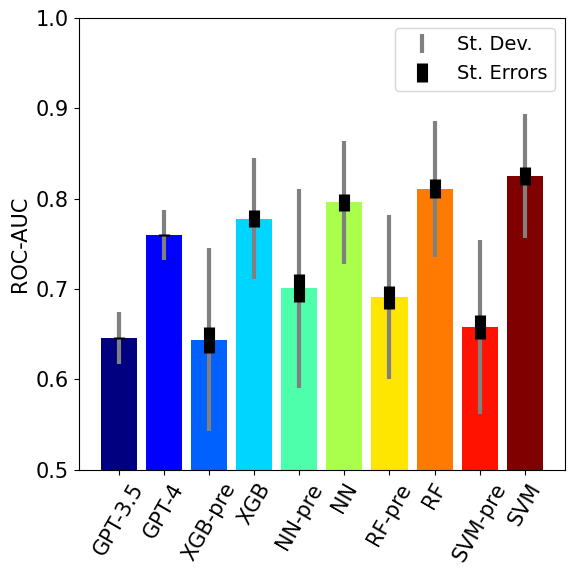

In [51]:

matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}
metrics = pd.read_csv('UL_metrics.csv')
aucs = {}
for col in metrics.columns:
  if 'auc' in col:
      key = col.replace('_pre','-pre')
      aucs[key]=[round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3),len(metrics[col])]
aucs['GPT-3.5'] = auc_gpt_summary['GPT-3.5']
aucs['GPT-4'] = auc_gpt_summary['GPT-4']
aucs = pd.DataFrame(aucs)
cols = ['GPT-3.5', 'GPT-4','XGB-pre_auc','XGB_auc', 'NN-pre_auc', 'NN_auc','RF-pre_auc', 'RF_auc', 'SVM-pre_auc', 'SVM_auc']
bars = [aucs[c][0] for c in cols]
stds = [aucs[c][1] for c in cols]

ax,fig = plt.subplots(1,1,figsize=(6,6))
errors = [aucs[c][1]/np.sqrt(aucs[c][2]) for c in cols]
jet = plt.get_cmap('jet')
plt.bar(list(range(len(cols))),bars,color=[jet(i/(len(cols)-1)) for i in range(len(cols))])
plt.errorbar(list(range(len(cols))),bars,yerr=stds,color='gray',linestyle='',linewidth=3,label='St. Dev.')

plt.errorbar(list(range(len(cols))),bars,yerr=errors,color='k',linewidth=8,alpha=1,linestyle='',label='St. Errors')
plt.xticks(list(range(len(cols))),[c.split('_')[0] for c in cols],rotation=60)
plt.ylabel('ROC-AUC')
plt.legend(fontsize=14,loc='upper right')
plt.ylim([0.5,1.0])
plt.tight_layout()
plt.savefig('AUC_UL.pdf',transparent=True)
plt.show()

### Apply best model to unlabeled urban legends data

In [23]:
# applying NN to understand hazards in ULs
filename = 'finalized_model_SVM_UL.sav'
model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')#'all-MiniLM-L6-v2')

clf = pk.load(open(filename,'rb'))#SVC(probability=True)
unlabeled_data_SNOPES = pd.read_excel('Urban Legend Data_ 2022 Snopes, Encyclopedia & 2014.xlsx',sheet_name='992 SNOPES LEGENDS')

unlabeled_data_SNOPES = pd.merge(unlabeled_data_SNOPES,pd.read_csv('unlabeled_SNOPES.csv'),on='LEGEND TEXT ')
unlabeled_data_SNOPES['summary_embedding'] = [e for e in model.encode(unlabeled_data_SNOPES['summary'].values)]
#unlabeled_data_SNOPES['hazard_pred'] = clf.predict_proba([u for u in unlabeled_data_SNOPES['summary_embedding'].values])

unlabeled_data_SNOPES['hazard_pred'] = [clf.predict_proba([u])[0,1] for u in unlabeled_data_SNOPES['summary_embedding'].values]
unlabeled_data_Enc = pd.read_excel('Urban Legend Data_ 2022 Snopes, Encyclopedia & 2014.xlsx',sheet_name='255 Encyclopedia Of Urban Legen')
unlabeled_data_Enc = unlabeled_data_Enc[['NARRATIVE MYTH/Legend Title ','LEGEND TEXT ']]
unlabeled_data_Enc = pd.merge(unlabeled_data_Enc,pd.read_csv('unlabeled_Enc.csv'),on=['LEGEND TEXT ','NARRATIVE MYTH/Legend Title '])
unlabeled_data_Enc.columns = ['title','text','summary']

#unlabeled_data_Enc['summary_embedding'] = model.encode(unlabeled_data_Enc['summary'].values)
unlabeled_data_Enc['summary_embedding'] = [e for e in model.encode(unlabeled_data_Enc['summary'].values)]
#unlabeled_data_Enc['hazard_pred'] = clf.predict_proba(unlabeled_data_Enc['summary_embedding'].values)
unlabeled_data_Enc['hazard_pred'] = [clf.predict_proba([u])[0,1] for u in unlabeled_data_Enc['summary_embedding'].values]

unlabeled_data_SNOPES.to_csv('unlabeled_data_SNOPES.csv',index=False)
unlabeled_data_Enc.to_csv('unlabeled_data_Enc.csv',index=False)


### Here is what the embedding looks like...

In [24]:
# First make a sentence embedding for each urban legend

embed_model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')
embeddings = embed_model.encode(labeled_data['summary'].values.astype(str))
X = embeddings
y = labeled_data['hazard'].values.round()

#Condense results to 2 dimensions with UMAP
fit = umap.UMAP()
all_embeddings = np.concatenate([X,np.array([e for e in unlabeled_data_Enc['summary_embedding'].values]),np.array([e for e in unlabeled_data_SNOPES['summary_embedding'].values])])

trans = fit.fit(all_embeddings)


umap_embed = trans.transform(X)
labeled_data['umap_x']=umap_embed[:,0]
labeled_data['umap_y']=umap_embed[:,1]


umap_embed = trans.transform(np.array([e for e in unlabeled_data_SNOPES['summary_embedding'].values]))
unlabeled_data_SNOPES['umap_x']=umap_embed[:,0]
unlabeled_data_SNOPES['umap_y']=umap_embed[:,1]


umap_embed = trans.transform(np.array([e for e in unlabeled_data_Enc['summary_embedding'].values]))
unlabeled_data_Enc['umap_x']=umap_embed[:,0]
unlabeled_data_Enc['umap_y']=umap_embed[:,1]

unlabeled_data_SNOPES.to_csv('unlabeled_data_SNOPES.csv',index=False)
unlabeled_data_Enc.to_csv('unlabeled_data_Enc.csv',index=False)
labeled_data.to_csv('Cleaned_2014_data.csv',index=False)

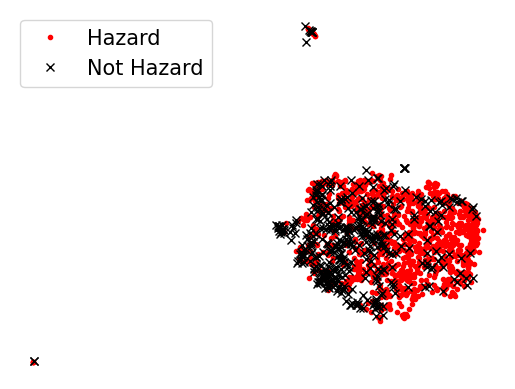

In [28]:
#all_embeddings = np.concatenate([X,unlabeled_data_Enc['summary_embedding'].values,unlabeled_data_SNOPES['summary_embedding'].values],axis=1)

matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}

all_umap_x_hazard = pd.concat([labeled_data.loc[labeled_data['hazard']>0.5,'umap_x'],unlabeled_data_SNOPES.loc[unlabeled_data_SNOPES['hazard_pred']>0.5,'umap_x'],unlabeled_data_Enc.loc[unlabeled_data_Enc['hazard_pred']>0.5,'umap_x']])
all_umap_y_hazard = pd.concat([labeled_data.loc[labeled_data['hazard']>0.5,'umap_y'],unlabeled_data_SNOPES.loc[unlabeled_data_SNOPES['hazard_pred']>0.5,'umap_y'],unlabeled_data_Enc.loc[unlabeled_data_Enc['hazard_pred']>0.5,'umap_y']])
all_umap_x_nohazard = pd.concat([labeled_data.loc[labeled_data['hazard']<0.5,'umap_x'],unlabeled_data_SNOPES.loc[unlabeled_data_SNOPES['hazard_pred']<0.5,'umap_x'],unlabeled_data_Enc.loc[unlabeled_data_Enc['hazard_pred']<0.5,'umap_x']])
all_umap_y_nohazard = pd.concat([labeled_data.loc[labeled_data['hazard']<0.5,'umap_y'],unlabeled_data_SNOPES.loc[unlabeled_data_SNOPES['hazard_pred']<0.5,'umap_y'],unlabeled_data_Enc.loc[unlabeled_data_Enc['hazard_pred']<0.5,'umap_y']])
plt.plot(all_umap_x_hazard,all_umap_y_hazard,'r.',label='Hazard')
plt.plot(all_umap_x_nohazard,all_umap_y_nohazard,'kx',label='Not Hazard')
plt.legend()
plt.axis('off')
plt.show()



### Proportion of hazard and non-hazard urban legends

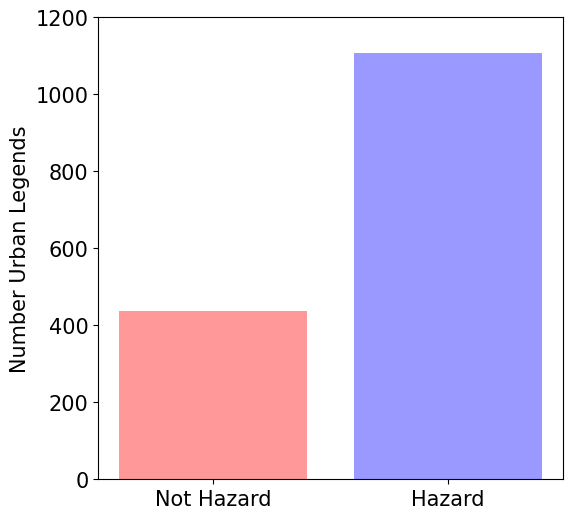

In [29]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
plt.bar([0,1],[len(all_umap_x_nohazard),len(all_umap_x_hazard)],color=['r','b'],alpha=0.4)
plt.ylabel('Number Urban Legends')
plt.xticks([0,1],['Not Hazard','Hazard'])
plt.ylim([0,1200])
plt.show()

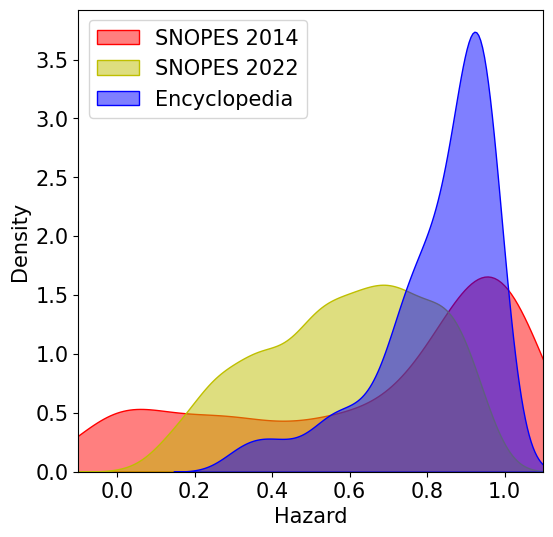

In [30]:
matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}
unlabeled_data_SNOPES = pd.read_csv('unlabeled_data_SNOPES.csv')
unlabeled_data_Enc= pd.read_csv('unlabeled_data_Enc.csv')
fig,ax=plt.subplots(1,1,figsize=(6,6))
sns.kdeplot(labeled_data['mean_hazard'],color='r',fill=True,alpha=0.5,label='SNOPES 2014')
sns.kdeplot(unlabeled_data_SNOPES['hazard_pred'],color='y',fill=True,alpha=0.5,label='SNOPES 2022')
sns.kdeplot(unlabeled_data_Enc['hazard_pred'],color='b',fill=True,alpha=0.5,label='Encyclopedia')
plt.legend(loc='upper left')
plt.xlabel('Hazard')
plt.xlim([-0.1,1.1])
plt.savefig('UL_comparisons.pdf',transparent=True)
plt.show()

### Same as above but combining all data

Text(0.5, 0, 'Hazard')

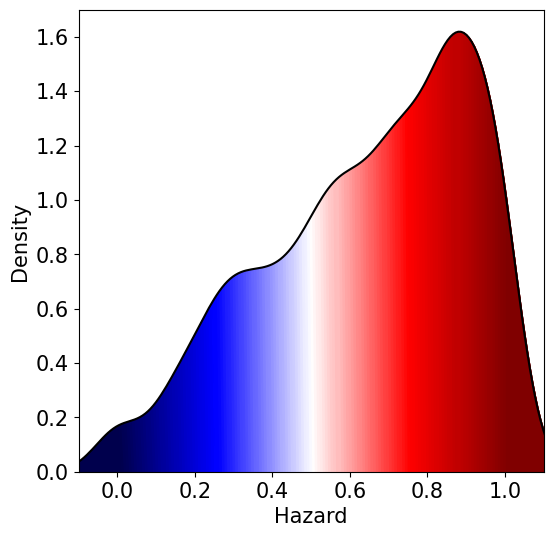

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,6))

all_legends = np.concatenate([labeled_data['mean_hazard'].values,unlabeled_data_SNOPES['hazard_pred'].values,unlabeled_data_Enc['hazard_pred'].values])
ax=sns.kdeplot(all_legends,color='k')
plt.xlim([-0.1,1.1])
kde_x, kde_y = ax.lines[0].get_data()
dx=0.007
for x0 in np.arange(-0.1,1.1,dx):
    ax.fill_between(kde_x, kde_y, where=(kde_x>x0) & (kde_x<=x0+3*dx) ,
                interpolate=True, color=plt.cm.seismic(x0))
plt.xlabel('Hazard')
